In [1]:
import rasterio as rio
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import numpy as np
import slidingwindow as sw

import pandas as pd
import matplotlib.pyplot as plt

from rasterio.plot import show

import numpy as np

# import tensorflow as tf 

In [2]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [3]:
## Create a quick and simple plotting function to help check on our results as we progress
def plot(image, w=12, h=12, cmap='Greys'):
    f, ax = plt.subplots(1, figsize=(w,h))
    ax.axis('off')
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.show()



# Parameters

In [4]:
file_name = '../green_blue_tool/Ground_truth_data/tiff_georef/SITU BABAKAN/SITU BABAKAN_RGB.tif'

dataset = rasterio.open(file_name)

meta_data = dataset.profile


In [5]:
dataset

<open DatasetReader name='../green_blue_tool/Ground_truth_data/tiff_georef/SITU BABAKAN/SITU BABAKAN_RGB.tif' mode='r'>

In [6]:
# show(dataset)

In [7]:
import fiona

# load libraries
from shapely.geometry import Polygon, MultiPolygon, MultiLineString, LineString
from shapely.geometry import Point
from shapely.geometry import shape

# load polygons
path ='./shapes/trash_line_points.shp' # './shapes/trash_line_points.shp' #  


shapefile_data = [pol['geometry'] for pol in fiona.open(path)]

Multi = []

for pol in shapefile_data:
    try:
        Multi.append(shape(pol))
    except:
        continue
        



s_line = Multi

nr_points = len(s_line)



In [8]:
len(Multi)

237

In [9]:
import itertools

        
points = list(itertools.chain.from_iterable([point[:] for point in [line.coords for line in s_line]]))


pd.DataFrame(points).shape


(237, 2)

In [10]:
#s_line.coords[1:100:10]

In [11]:
import random

# random array with no duplicates
rand_array = random.sample(range(nr_points), 50) # np.random.randint(0, nr_points, size=len(Multi))

rand_array = np.array(rand_array)

rand_array

array([236, 220,  22, 231, 126,  16,  55,  81,  34, 128,  20,  39,  18,
        69, 211, 102,   2,  44,  67, 180,  53, 194, 155, 120, 182,  46,
        98, 101, 219,  60, 214,  15, 167,  77,  25,  52,  71,  68, 225,
       163,  62,  26, 122, 181, 121,  36,   0,  64, 139,  74])

In [12]:
out_meta = dataset.meta.copy()

epsg_code = int(dataset.crs.data['init'][5:])

origin_x = out_meta['transform'][2]
origin_y = out_meta['transform'][5]

pix_x_size = out_meta['transform'][0]
pix_y_size = out_meta['transform'][4]

In [13]:
out_meta['transform']

Affine(0.049999999999998455, 0.0, 700728.2472385319,
       0.0, -0.05000000000002458, 9299166.562988434)

In [14]:
# define parameters

import math

minx, miny, maxx, maxy = 701270.4,9298311.5, 701274.5,9298315.3



patch_size = 256

stepsize_x = (patch_size / 2) * pix_x_size

stepsize_y = (patch_size / 2) * pix_y_size


n_points = 50 #len(Multi)

columns = 10

i = 0

nrows = math.ceil(n_points / columns)

# Make new data
### Check folder: /trash & /non-trash if there is no data run this part, otherwise not neccesary, start at "load data" 

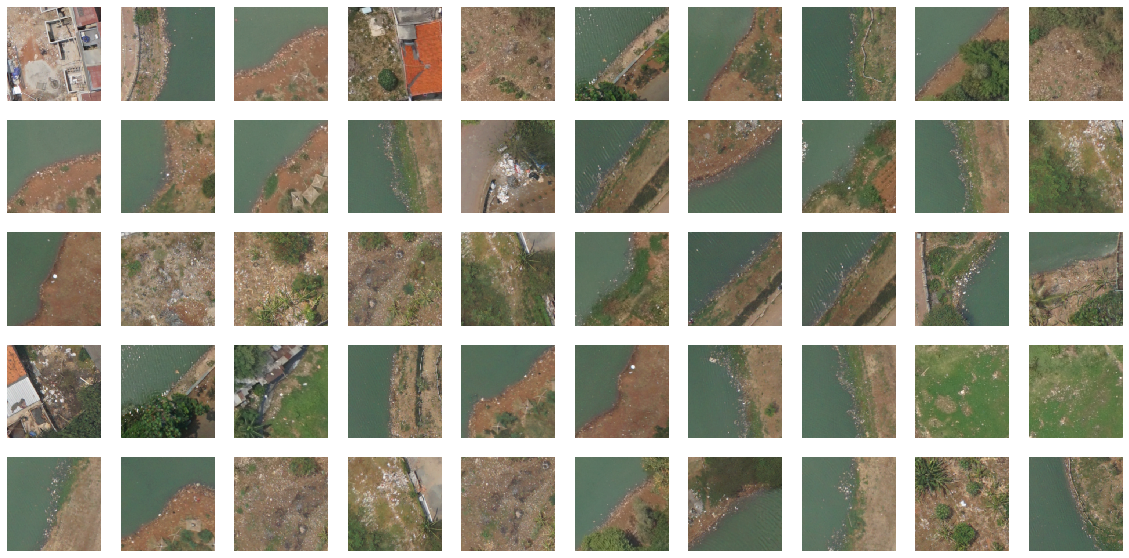

In [15]:
fig, axs = plt.subplots(nrows, columns, figsize=(10*2,5*2))
fig
axs = axs.ravel()


for index in rand_array: #points[0:n_points]:
    
    x,y = points[int(index)]
    
    # x,y = point
    
    x = (int(round((x - origin_x) / pix_x_size)) * pix_x_size) + origin_x
    y = (int(round((y - origin_y) / pix_y_size)) * pix_y_size) + origin_y

    minx = x - stepsize_x
    miny = y - stepsize_y
    maxx = x + stepsize_x
    maxy = y + stepsize_y
    
    
    bbox = box(minx, miny, maxx, maxy)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(32748))
    coords = getFeatures(geo)
    out_img, out_transform = mask(dataset, shapes=coords, crop=True)
    
    if out_img.shape[1] > patch_size:
        out_img = out_img[:,0:patch_size,:]
        
    if out_img.shape[2] > patch_size:
        out_img = out_img[:,:,0:patch_size]
    
    out_meta.update({"driver": "GTiff",
                        "height": out_img.shape[1],
                        "width": out_img.shape[2],
                        "transform": out_transform})
    
    
    out_img_rgb = np.reshape(out_img.T,[out_img.shape[2],out_img.shape[1],out_img.shape[0]])
    
    
    axs[i].imshow(out_img_rgb)
    axs[i].axis('off')
    
    i = i + 1

    # print(x,y)
    
    # plt.show()
    
    x = '1' # input('trash? (y/n = 1/0)')
    
    if x == '1':
        with rasterio.open('trash/{}.tif'.format([x,y]), "w", **out_meta) as dest:
            dest.write(out_img)
    else: 
        with rasterio.open('non_trash/{}.tif'.format([x,y]), "w", **out_meta) as dest:
            dest.write(out_img)
        
        
plt.show()  

In [16]:
out_img.shape

(3, 256, 256)

# load data from folders

In [206]:
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread, imread_collection
import skimage.io as io
from scipy import misc
from skimage import data, color, feature, exposure
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from random import sample
import glob

In [207]:
## Grab File List 

path_positive = '../../data/cloud_detection/cloud/*.jpg'
path_negative = '../../data/cloud_detection/non_cloud/*.jpg'

totalNegative = (glob.glob(path_negative))
totalPositive = (glob.glob(path_positive))
print ("Negative Files: {}".format(len(totalNegative)))
print ("Positive Files: {}".format(len(totalPositive)))

Negative Files: 6215
Positive Files: 4324


In [208]:
## Use the file list from before, but select a subset of images randomly using sample

rand_positive = totalPositive
rand_negative = sample(totalNegative,50)

positives = imread_collection(path_positive, conserve_memory=True)
negatives = imread_collection(path_negative, conserve_memory=True)

In [209]:
def transformImage(f, img_num=None):
        img = io.imread(f)
#         img_gray = rgb2gray(img)        
#         im_res = resize(img_gray,(patch_size,patch_size))

        return img


positives = io.ImageCollection(path_positive, load_func=transformImage)
negatives = io.ImageCollection(path_negative, load_func=transformImage)

In [210]:
len(negatives), len(positives)

(6215, 4324)

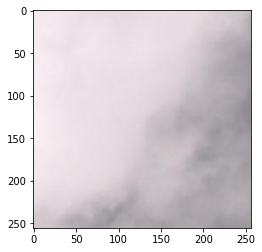

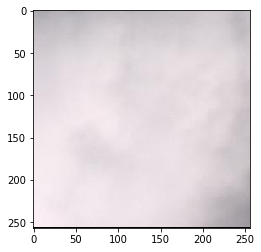

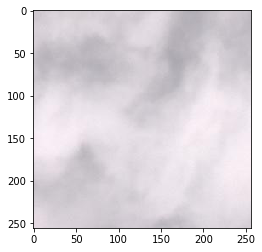

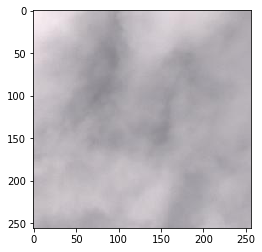

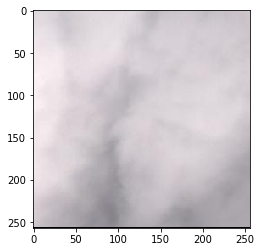

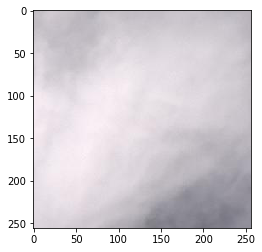

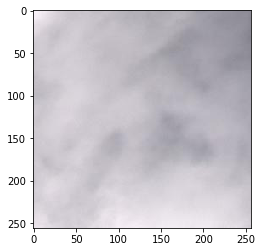

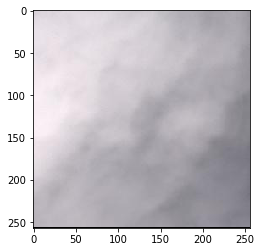

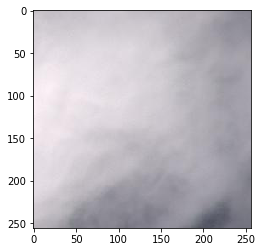

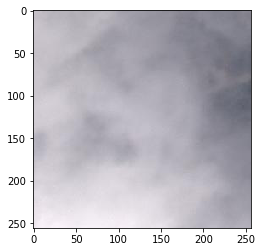

In [130]:
for i in range(10):
    plt.imshow(positives[i])
    plt.show()

In [211]:
# select subset for training

positives = positives[0:1000]
negatives = negatives[0:1000]

# Feature engineering

## HOG

In [212]:
#compute some hog features, oink oink

oink_vec, oink_vis = feature.hog(positives[0], visualize=True)

In [213]:
import skimage
skimage.__version__

'0.16.2'

In [214]:
# oink_vis = greycomatrix(positives[1][:,:,1], [5], [0], 256, symmetric=True, normed=True)

# oink_vis = np.reshape(oink_vis,[256,256])

# # greycoprops(oink_vis, 'dissimilarity')[0, 0]
# oink_vis.shape

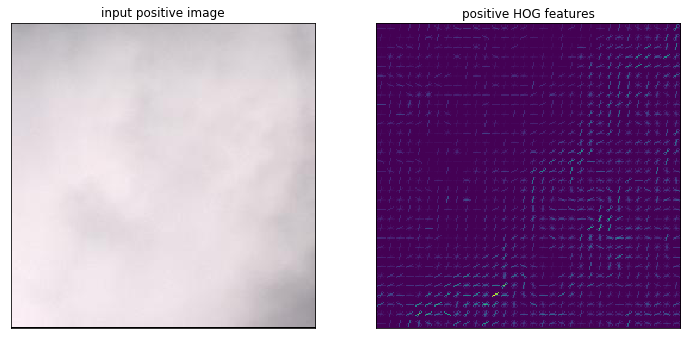

In [215]:
#look at our features!

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(positives[1], cmap='gray')
ax[0].set_title('input positive image')

ax[1].imshow(oink_vis)
ax[1].set_title('positive HOG features');

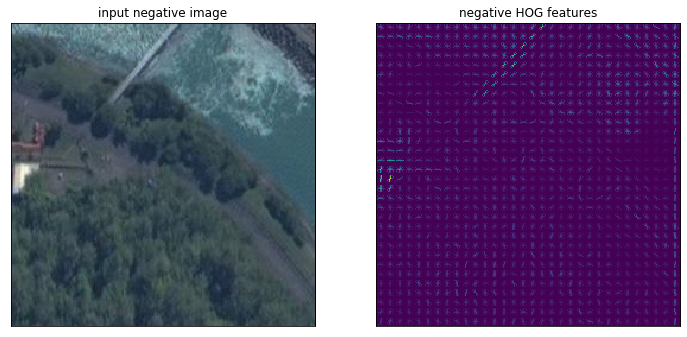

In [216]:
#compute some hog features, oink oink, again. 

oink_vec2, oink_vis2 = feature.hog(negatives[0], visualize=True)

#and look at these new features!

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(negatives[0], cmap='gray')
ax[0].set_title('input negative image')

ax[1].imshow(oink_vis2)
ax[1].set_title('negative HOG features');


In [217]:
## Generate Features for both training sets
X_train = np.array([feature.hog(im) for im in chain(positives,negatives)])

# X_train_pos = np.array([feature.hog(im) for im in positives])

# X_train_neg = np.array([feature.hog(im) for im in negatives])

In [218]:
X_train.shape

(2000, 72900)

In [219]:
import gc
gc.collect()

92114

# Test grey comatrix 

In [181]:
from skimage.feature import greycomatrix, greycoprops


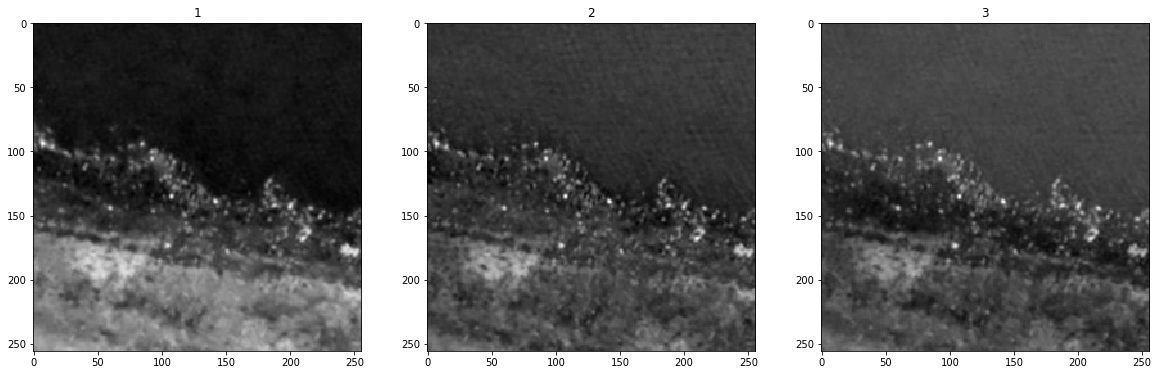

In [182]:
fig = plt.figure(figsize = (20,30))

plt.subplot(131)
plt.imshow(positives[10][:,:,0],cmap='gray')
plt.title('1')
plt.subplot(132)
plt.imshow(positives[10][:,:,1],cmap='gray')
plt.title('2')
plt.subplot(133)
plt.imshow(positives[10][:,:,2],cmap='gray')
plt.title('3')



glcm = greycomatrix(positives[10][:,:,1], [5], [0], 256, symmetric=True, normed=True)

In [183]:
glcm.shape

(256, 256, 1, 1)

In [184]:
greycoprops(glcm, 'contrast')[0, 0]

71.82725348605575

In [185]:
glcm.shape

(256, 256, 1, 1)

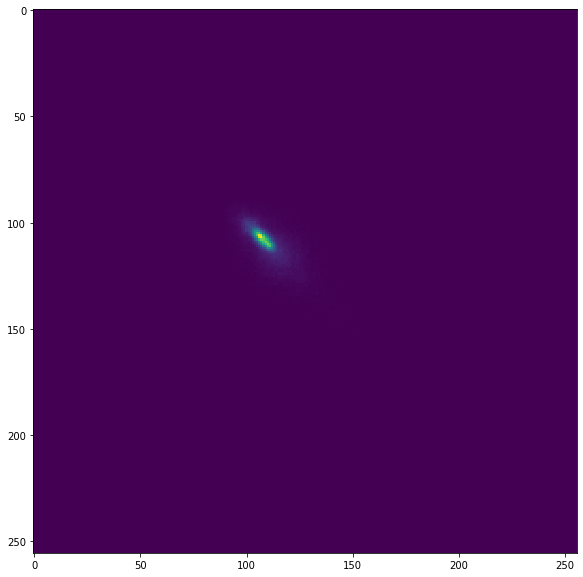

In [186]:
fig = plt.figure(figsize=(10,10))

plt.imshow(glcm[:,:,0,0])

In [ ]:
xs = []
ys = []

collist = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']

df = pd.DataFrame(columns = collist)



for patch in chain(positives,negatives):
    
    
    patch = patch[100:150,100:150,0]
    
    glcm = greycomatrix(patch, [5], [0], 256, symmetric=True, normed=True)
    
    
    # prop : {‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’}, optional
    
    
    cont   = greycoprops(glcm, 'correlation')[0, 0]
    dis    = greycoprops(glcm, 'dissimilarity')[0, 0]
    hom    = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    corr   = greycoprops(glcm, 'correlation')[0, 0]
    ASM    = greycoprops(glcm, 'ASM')[0, 0]
    
    print([cont, dis, hom, energy, corr, ASM])
    
    df2 = pd.DataFrame([cont, dis, hom, energy, corr, ASM], columns=collist)
    
    df.append(df2)

In [ ]:
df2 = pd.DataFrame([cont, dis, hom, energy, corr, ASM], columns=collist)

In [42]:
df

Empty DataFrame
Columns: [contrast, dissimilarity, homogeneity, energy, correlation, ASM]
Index: []

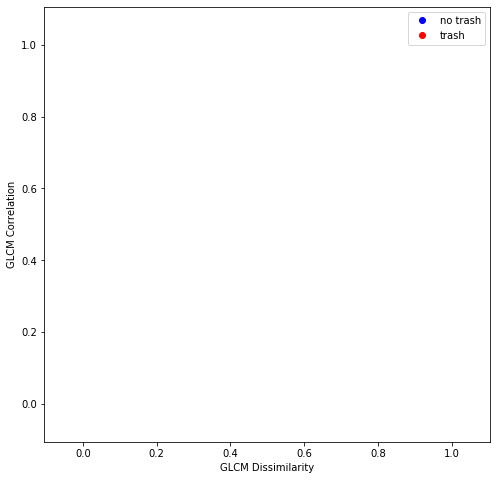

In [43]:
# create the figure
fig = plt.figure(figsize=(8, 8))

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(1,1,1)

ax.plot(xs[len(negatives):], ys[len(negatives):], 'bo',
        label='no trash')


ax.plot(xs[:len(positives)], ys[:len(positives)], 'ro',
        label='trash')


ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

plt.show()

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns


### end gray comatrix

# Test blobdetection

In [81]:
rand_array = random.sample(range(50), 20) # np.random.randint(0, nr_points, size=len(Multi))


rand_array

[28,
 36,
 20,
 29,
 35,
 38,
 46,
 45,
 16,
 40,
 18,
 47,
 15,
 10,
 13,
 12,
 39,
 22,
 11,
 30]

In [83]:
index

143

In [ ]:
positives[index].shape

### impression

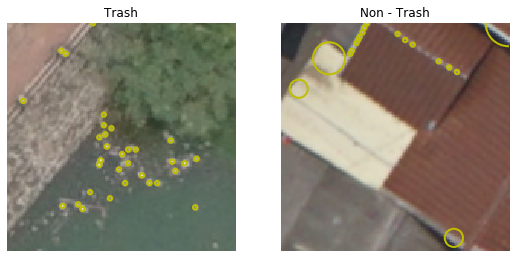

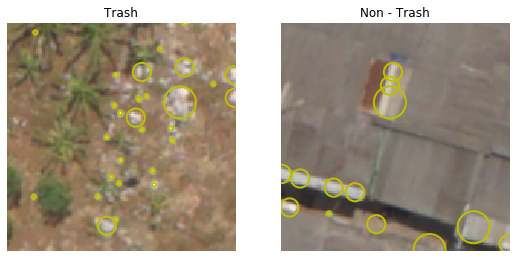

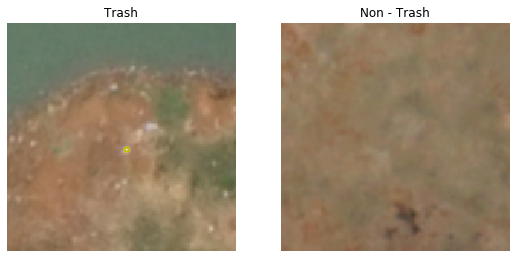

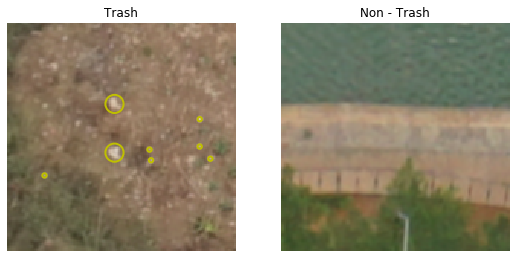

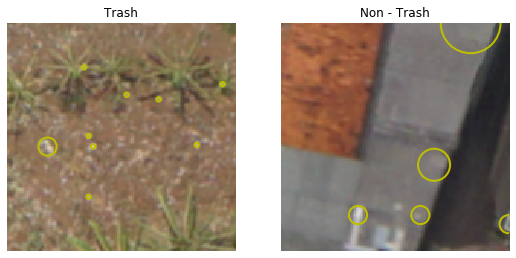

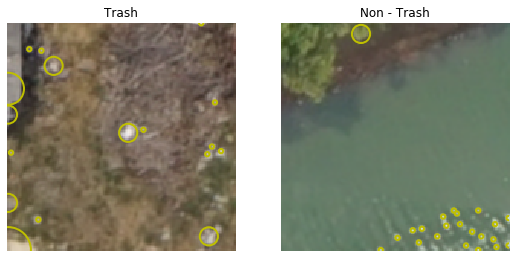

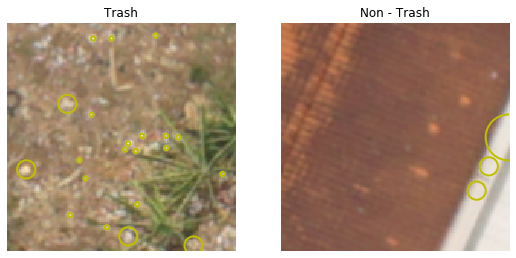

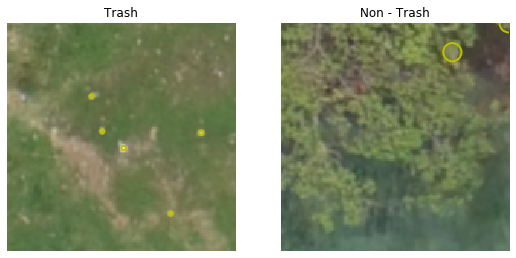

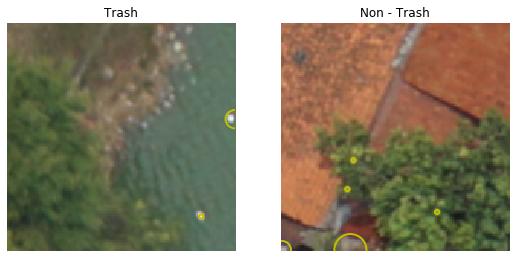

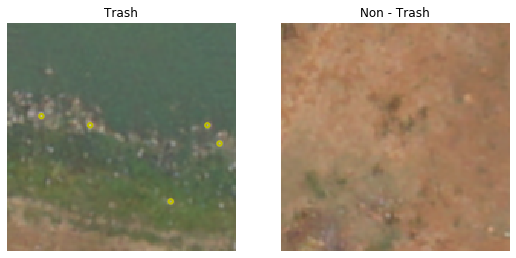

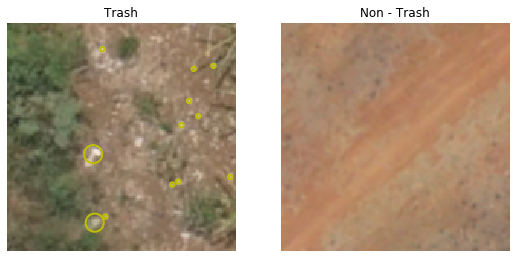

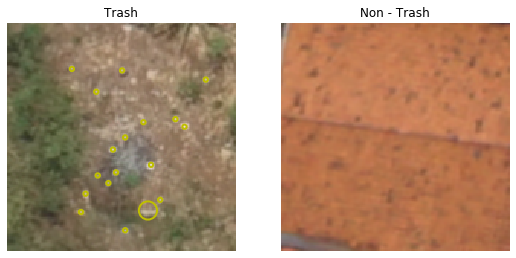

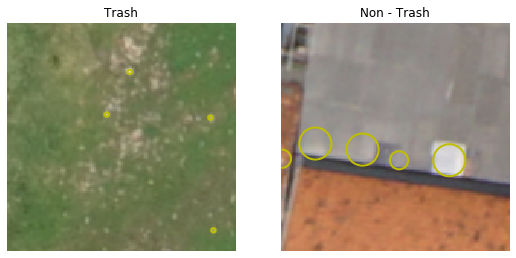

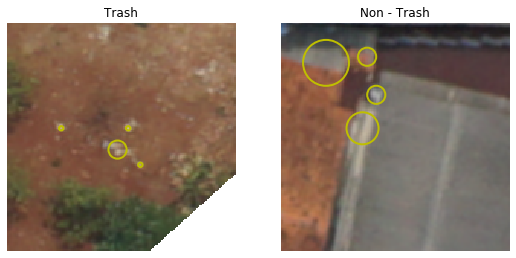

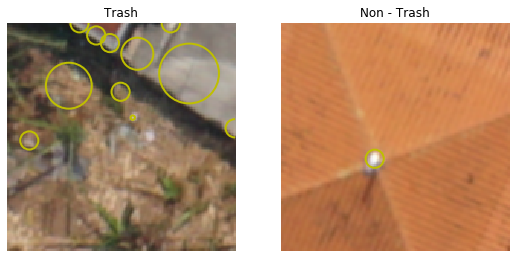

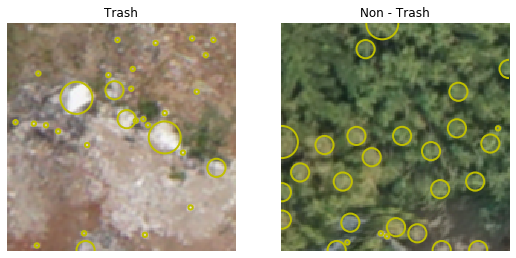

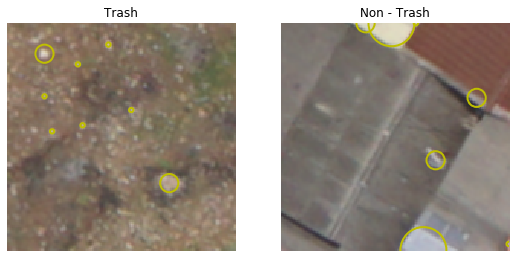

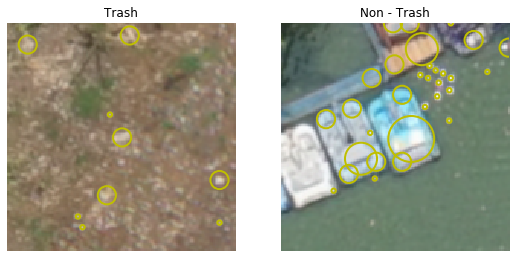

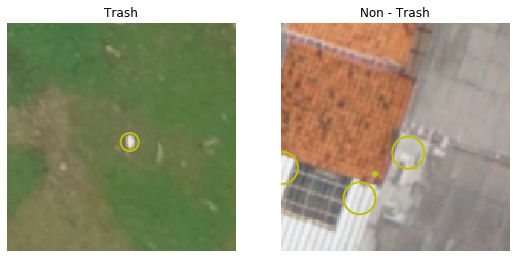

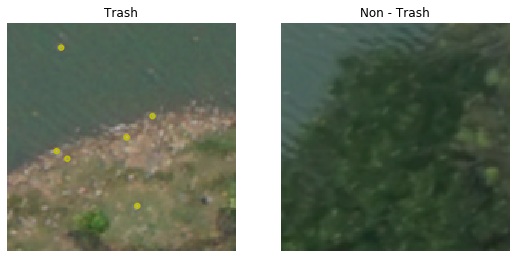

In [84]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

min_r = 1

max_r = 20

plot = True


r_pos = list()
r_neg = list()

for index in rand_array:
    
    image = positives[index][50:200,50:200]
    
    image_gray = rgb2gray(image)

    blobs_logp = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)
    
    r_pos = r_pos + list(pd.DataFrame(blobs_logp)[2])
    
    # Compute radii in the 3rd column.
    blobs_logp[:, 2] = blobs_logp[:, 2] * sqrt(2)

    blobs_listp = blobs_logp
    color = 'y'
    title = 'Trash'
    

    
    
    # positive
    
    if plot == True:
        
        fig, axes = plt.subplots(1, 2, figsize=(9, 10), sharex=False, sharey=False)
        ax = axes.ravel()

        ax[0].set_title(title)
        ax[0].imshow(image, interpolation='nearest')
        for blob in blobs_listp:
            y, x, r = blob

            if (r >= min_r) & (r < max_r): 
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax[0].add_patch(c)
        ax[0].set_axis_off()


    
        
    # negative
    
    image = negatives[index][50:200,50:200]
    
    image_gray = rgb2gray(image)

    blobs_logn = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)

    # Compute radii in the 3rd column.
    blobs_logn[:, 2] = blobs_logn[:, 2] * sqrt(2)
    
    r_neg = r_neg + list(pd.DataFrame(blobs_logn)[2])

    blobs_listn = blobs_logn
    color = 'y'
    title = 'Non - Trash'


 
    
    # negative
    
    if plot == True:
    
        ax[1].set_title(title)
        ax[1].imshow(image, interpolation='nearest')
        for blob in blobs_listn:
            y, x, r = blob

            if (r >= min_r) & (r < max_r): 
                c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
                ax[1].add_patch(c)
        ax[1].set_axis_off()

    

    
        # plt.tight_layout()
        plt.show()

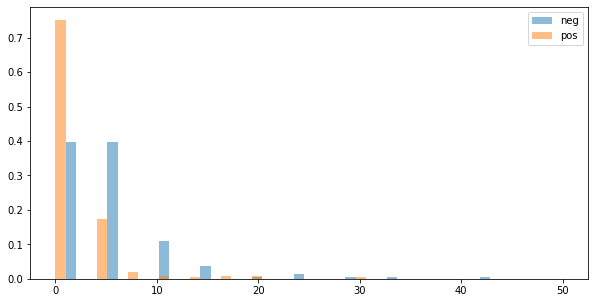

In [86]:
bins = np.linspace(0, 50, 50)

fig =  plt.figure(figsize=(10, 5))
# fig.gca().set_yscale('log')

plt.hist(r_neg, bins, alpha=0.5, label='neg', density=True)
plt.hist(r_pos, bins, alpha=0.5, label='pos', density=True)
plt.legend(loc='upper right')
plt.show()

In [87]:
type(r_pos)

list

In [88]:
xblob = []
yblob = []

for image in chain(positives,negatives):
  
    image_gray = rgb2gray(image)

    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)
    
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    
    y = len(pd.DataFrame(blobs_log)[0])
    r = pd.DataFrame(blobs_log)[2]
    
    xblob.append(np.std(r))
    yblob.append(y)

In [89]:
xblob = []
yblob = []

for image in positives[0:5]:
  
    image_gray = rgb2gray(image)

    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.1)
    
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    
    y = len(pd.DataFrame(blobs_log)[0])
    r = pd.DataFrame(blobs_log)[2]
    
    xblob.append(np.std(r))
    yblob.append(y)

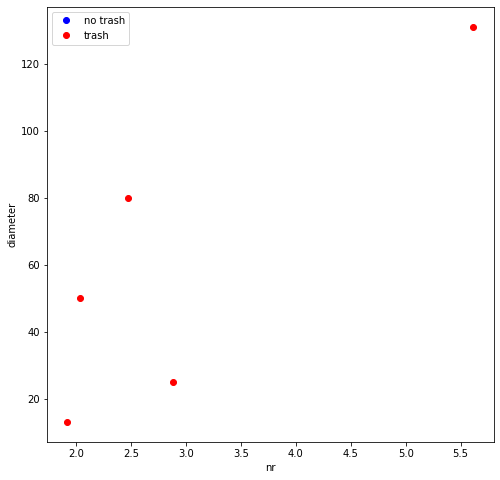

In [90]:
# create the figure
fig = plt.figure(figsize=(8, 8))

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(1,1,1)


ax.plot(xblob[len(negatives):], yblob[len(negatives):], 'bo',
        label='no trash')

ax.plot(xblob[:len(positives)], yblob[:len(positives)], 'ro',
        label='trash')




ax.set_xlabel('nr')
ax.set_ylabel('diameter')
ax.legend()

plt.show()

### end blob

In [220]:
## Generate binary 1,0 classification for positive and negative
y_train = np.zeros(X_train.shape[0])
y_train[:np.array(positives).shape[0]] = 1

## Look at the dimensions of our training data
X_train.shape

(2000, 72900)

In [221]:
np.unique(y_train, return_counts = True)

(array([0., 1.]), array([1000, 1000]))

In [222]:
from sklearn.model_selection import train_test_split  

(X_train, X_test, y_train, y_test) = train_test_split(X_train, y_train, test_size=0.25)

In [223]:
y_train.shape

(1500,)

In [224]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.83      , 0.77      , 0.79333333, 0.77      , 0.79666667])

In [225]:
# Fit random forest classifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

rf_grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           verbose = 1,
                           n_jobs = 4)

rf_grid_search.fit(X_train, y_train)
print('Best score random forest classifier: {}'.format(rf_grid_search.best_score_))
print('Best parameters random forest classifier: {}'.format(rf_grid_search.best_params_))

rf_grid_search.best_estimator_

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:  4.7min finished


Best score random forest classifier: 0.818
Best parameters random forest classifier: {'criterion': 'gini', 'max_features': 4, 'n_estimators': 100}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [226]:
from sklearn.metrics import classification_report

y_pred = rf_grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       260
         1.0       0.79      0.86      0.82       240

    accuracy                           0.82       500
   macro avg       0.83      0.83      0.82       500
weighted avg       0.83      0.82      0.82       500



In [227]:
! notify-send 'Training done' $(date '+%H:%M:%S') -u critical -i face-smile

## train naive bayes

In [151]:
## Fit the Naive Bayes
nbModel = GaussianNB()
nbModel.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

# Inference

In [228]:
# find files 

inference_file_path = '../../data/rasters_waterbodies_osm/cloud_images/Balikpapan_039*.tif'

inference_file_list = (glob.glob(inference_file_path))

inference_file_list[0:5]

['../../data/rasters_waterbodies_osm/cloud_images/Balikpapan_039_pansharpen_True_2018-12-02_02:49_1030010089C5D200.tif']

In [229]:
# get image 

dataset = rasterio.open(inference_file_list[0])

meta_data = dataset.profile

out_img = dataset.read()


# dia_image = np.reshape(out_img.T,[out_img.shape[2],out_img.shape[1],out_img.shape[0]])

In [ ]:
# get bbox
minx, miny, maxx, maxy = 701327.9, 9298248.6, 701759.6, 9298646.4
bbox = box(minx, miny, maxx, maxy)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(32748))
coords = getFeatures(geo)
out_img, out_transform = mask(dataset, shapes=coords, crop=True)
out_meta.update({"driver": "GTiff",
                    "height": out_img.shape[1],
                    "width": out_img.shape[2],
                    "transform": out_transform})

In [230]:
out_img.shape

(8, 4637, 4945)

In [231]:
patch_size

256

In [232]:
## define a sliding window function

def sliding_window(img, patch_size=[patch_size,patch_size],
                   istep=int(patch_size/2), jstep=int(patch_size/2), scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

In [233]:
## Generate features and indices 

windows = [feature.hog(t[1]) for t in sliding_window(out_img[0,:,:],patch_size=[patch_size,patch_size])]
indices = [t[0] for t in sliding_window(out_img[0,:,:],patch_size=[patch_size,patch_size])]

In [234]:
# separate out indices
indices = np.array(indices)
a = np.vstack(windows)



## use bayes

In [183]:
# predict new labels
labels = nbModel.predict(a)

# use RandomForestClassifier

In [235]:
# predict new labels
labels = rf_grid_search.predict(a)

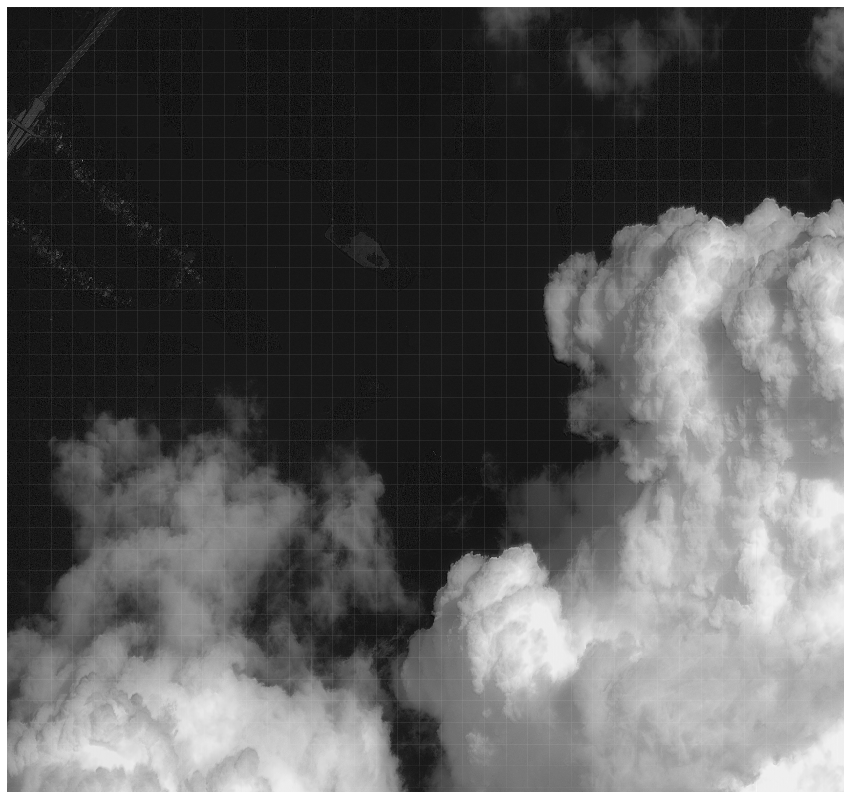

In [236]:
#plot the predictions:
fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)    
ax.imshow(out_img[0,:,:], cmap='gray')
ax.axis('off')

Ni, Nj = [256,256]
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='none',
                               alpha=0.2, lw=2, facecolor='red'))

for i, j in indices:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='white',
                               alpha=0.02, lw=1, facecolor='none'))

In [237]:
np.unique(labels)

array([0.])